In [203]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import json

In [238]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [239]:
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

print(test_enc_name)

_BatchCorTrue_NanRemTrue_minmax


In [240]:
data_tmp = pd.read_excel(os.path.join(data_path,'raw_data.xlsx'))
data_tmp.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time\n(min),UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,6.142877e+07,0.001197,1.963161e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,6.142877e+07,0.007075,1.490595e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,6.142877e+07,0.041642,8.628739e+07,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,6.142877e+07,0.036870,1.080535e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,6.142877e+07,0.001575,2.723486e+06,4.165659e+07,0.001167


In [304]:
metadata = data_tmp.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, data_tmp.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, data_tmp.iloc[:,16]],axis=1)

data_stats = data.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()

,index,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [305]:
# We need the filktering session nof the pac_analysys.ipynb to filter the lipids
#data = data_stats.loc[data_stats['Individual Lipid Species'].isin(lipid_names)].copy(deep=True)
data = data_stats.copy(deep=True)
data.columns = ['Index','SampleNumber', 'SampleSubmissionDate', 'SampleName', 'Sex', 'TissueWeight', 'Treatment', 'TissueType', 'PND', 'Litter', 'IndividualLipidSpecies', 'LipidClass', 'PeakArea']
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


In [306]:
data['log_area'] = np.log10(data.iloc[:,-1])
data['log_scaled_area'] = scaler.fit_transform(data[['log_area']])
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea,log_area,log_scaled_area
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842,-3.074916,0.647776
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390,-2.194512,0.719944
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989,-1.431924,0.782454
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320,-1.334233,0.790462
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167,-2.932747,0.659430


In [307]:
def classify_date(input_date):
    if input_date == '09/2021':
        return 1
    else:
        return 2

data['dateId'] = data['SampleSubmissionDate'].apply(lambda x: classify_date(x))

In [308]:
df_sub = data[(data['TissueType'] == 'cortex') & (data['PND'] == 30)].copy()
df_sub['class'] = [0 if x == 'control' else 1 for x in df_sub['Treatment']]


In [309]:
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,TissueWeight,Treatment,TissueType,PND,Litter,IndividualLipidSpecies,LipidClass,PeakArea,log_area,log_scaled_area,dateId
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842,-3.074916,0.647776,1
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390,-2.194512,0.719944,1
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989,-1.431924,0.782454,1
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320,-1.334233,0.790462,1
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167,-2.932747,0.659430,1


In [310]:
gender = 'F'
tissue_type = 'cortex'
pnd = 30

In [311]:
""" def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1), np.var(d2)
    s = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 -2))
    u1, u2 = np.mean(d1), np.mean(d2)

    return (u1 - u2)/s """

' def cohend(d1, d2):\n    n1, n2 = len(d1), len(d2)\n    s1, s2 = np.var(d1), np.var(d2)\n    s = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 -2))\n    u1, u2 = np.mean(d1), np.mean(d2)\n\n    return (u1 - u2)/s '

In [312]:
# Extract the data from the dataframe

control_subjects = data[(data["Sex"] == gender) & (data["TissueType"] == tissue_type) & (data["PND"] == pnd) & (data["Treatment"] == 'control')]
dm_subjects = data[(data["Sex"] == gender) & (data["TissueType"] == tissue_type) & (data["PND"] == pnd) & (data["Treatment"] == 'deltamethrin')]

In [313]:
control_subject_by_lipid = control_subjects[["SampleName","IndividualLipidSpecies","log_scaled_area"]].groupby(["IndividualLipidSpecies"])\
    .agg(mean_log_scaled_area=('log_scaled_area','mean'),var_log_scaled_area=('log_scaled_area','var'),sample_number_control=('SampleName','count'))
control_subject_by_lipid

,mean_log_scaled_area,var_log_scaled_area,sample_number_control
IndividualLipidSpecies,,,
CE(14:0)+H,0.237256,0.168871,3
CE(16:0)+H,0.000000,0.000000,3
CE(16:1)+H,0.222991,0.149175,3
CE(18:0)+H,0.223518,0.149881,3
CE(18:1)+H,0.685606,0.003195,3
...,...,...,...
TAG(60:10_FA22:5)+NH4,0.523356,0.205449,3
TAG(60:10_FA22:6)+NH4,0.814705,0.000548,3
TAG(60:11_FA22:5)+NH4,0.814260,0.000836,3


In [314]:
dm_subject_by_lipid = dm_subjects[["SampleName","IndividualLipidSpecies","log_scaled_area"]].groupby(["IndividualLipidSpecies"])\
    .agg(mean_log_scaled_area=('log_scaled_area','mean'),var_log_scaled_area=('log_scaled_area','var'),sample_number_treatment=('SampleName','count'))
dm_subject_by_lipid

,mean_log_scaled_area,var_log_scaled_area,sample_number_treatment
IndividualLipidSpecies,,,
CE(14:0)+H,0.646413,0.000685,3
CE(16:0)+H,0.000000,0.000000,3
CE(16:1)+H,0.469286,0.165293,3
CE(18:0)+H,0.673241,0.003019,3
CE(18:1)+H,0.692904,0.000225,3
...,...,...,...
TAG(60:10_FA22:5)+NH4,0.511051,0.197592,3
TAG(60:10_FA22:6)+NH4,0.810489,0.000222,3
TAG(60:11_FA22:5)+NH4,0.794846,0.001516,3


In [315]:
control_subject_by_lipid_not_scled = control_subjects[["SampleName","IndividualLipidSpecies","log_area"]].groupby(["IndividualLipidSpecies"])\
    .agg(mean_log_area=('log_area','mean'),var_log_area=('log_area','var'),sample_number_control=('SampleName','count'))
dm_subject_by_lipid_not_scaled = dm_subjects[["SampleName","IndividualLipidSpecies","log_area"]].groupby(["IndividualLipidSpecies"])\
    .agg(mean_log_area=('log_area','mean'),var_log_area=('log_area','var'),sample_number_treatment=('SampleName','count'))
dm_subject_by_lipid_not_scaled

,mean_log_area,var_log_area,sample_number_treatment
IndividualLipidSpecies,,,
CE(14:0)+H,-3.091547,0.101954,3
CE(16:0)+H,-10.977429,0.000000,3
CE(16:1)+H,-5.252399,24.600032,3
CE(18:0)+H,-2.764260,0.449241,3
CE(18:1)+H,-2.524388,0.033509,3
...,...,...,...
TAG(60:10_FA22:5)+NH4,-4.742887,29.406925,3
TAG(60:10_FA22:6)+NH4,-1.089911,0.033060,3
TAG(60:11_FA22:5)+NH4,-1.280751,0.225664,3


In [316]:
individual_lipid_species_mean_var = pd.merge(control_subject_by_lipid, dm_subject_by_lipid, on="IndividualLipidSpecies")
individual_lipid_species_mean_var

,mean_log_scaled_area_x,var_log_scaled_area_x,sample_number_control,mean_log_scaled_area_y,var_log_scaled_area_y,sample_number_treatment
IndividualLipidSpecies,,,,,,
CE(14:0)+H,0.237256,0.168871,3,0.646413,0.000685,3
CE(16:0)+H,0.000000,0.000000,3,0.000000,0.000000,3
CE(16:1)+H,0.222991,0.149175,3,0.469286,0.165293,3
CE(18:0)+H,0.223518,0.149881,3,0.673241,0.003019,3
CE(18:1)+H,0.685606,0.003195,3,0.692904,0.000225,3
...,...,...,...,...,...,...
TAG(60:10_FA22:5)+NH4,0.523356,0.205449,3,0.511051,0.197592,3
TAG(60:10_FA22:6)+NH4,0.814705,0.000548,3,0.810489,0.000222,3
TAG(60:11_FA22:5)+NH4,0.814260,0.000836,3,0.794846,0.001516,3


In [317]:
individual_lipid_species_mean_var['means_difference'] = individual_lipid_species_mean_var['mean_log_scaled_area_x'] - individual_lipid_species_mean_var['mean_log_scaled_area_y']


In [318]:
individual_lipid_species_mean_var.sort_values(by="means_difference", inplace=True, ascending=False)
individual_lipid_species_mean_var.head(80)

,mean_log_scaled_area_x,var_log_scaled_area_x,sample_number_control,mean_log_scaled_area_y,var_log_scaled_area_y,sample_number_treatment,means_difference
IndividualLipidSpecies,,,,,,,
PC(18:0_14:0)+AcO,0.709831,0.000161,3,0.000000,0.000000,3,0.709831
DAG(18:1_22:5)+NH4,0.682556,0.001688,3,0.000000,0.000000,3,0.682556
CE(20:0)+H,0.680826,0.002317,3,0.000000,0.000000,3,0.680826
TAG(56:8_FA16:1)+NH4,0.782906,0.000641,3,0.245271,0.180473,3,0.537635
TAG(58:8_FA18:1)+NH4,0.522475,0.206099,3,0.000000,0.000000,3,0.522475
...,...,...,...,...,...,...,...
PS(14:0_20:3)-H,0.385118,0.111313,3,0.198846,0.118619,3,0.186271
TAG(53:2_FA16:0)+NH4,0.426609,0.136651,3,0.241935,0.175598,3,0.184673
PS(20:0_18:3)-H,0.572804,0.000626,3,0.389107,0.113581,3,0.183697


In [319]:
def get_necessary_number_of_samples(x):
    means_difference_value = x['means_difference']
    s_control = x['var_log_scaled_area_x']
    s_treatment = x['var_log_scaled_area_y']
    n_control = x['sample_number_control']
    n_treatment = x['sample_number_treatment']

    s = np.sqrt(((n_control - 1)*s_control + (n_treatment - 1)*s_treatment) / (n_control + n_treatment -2))

    if means_difference_value < 0.001:
        n_mice_ideal = 100
    else:
        es_mean = means_difference_value/s
        alpha = 0.05
        statisticalPower = 0.8
        n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)

    return  n_mice_ideal

In [320]:
individual_lipid_species_mean_var['sample_necessary_per_class'] = individual_lipid_species_mean_var.apply(lambda row: get_necessary_number_of_samples(row), axis=1)

c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\power.py:525: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\power.py:525: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\power.py:525: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\power.py:525: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


In [321]:
individual_lipid_species_mean_var['sample_necessary_per_class'].clip(0,50, inplace=True)

In [322]:
individual_lipid_species_mean_var.head(80)

,mean_log_scaled_area_x,var_log_scaled_area_x,sample_number_control,mean_log_scaled_area_y,var_log_scaled_area_y,sample_number_treatment,means_difference,sample_necessary_per_class
IndividualLipidSpecies,,,,,,,,
PC(18:0_14:0)+AcO,0.709831,0.000161,3,0.000000,0.000000,3,0.709831,[10.0]
DAG(18:1_22:5)+NH4,0.682556,0.001688,3,0.000000,0.000000,3,0.682556,[10.0]
CE(20:0)+H,0.680826,0.002317,3,0.000000,0.000000,3,0.680826,[10.0]
TAG(56:8_FA16:1)+NH4,0.782906,0.000641,3,0.245271,0.180473,3,0.537635,6.047385
TAG(58:8_FA18:1)+NH4,0.522475,0.206099,3,0.000000,0.000000,3,0.522475,7.029341
...,...,...,...,...,...,...,...,...
PS(14:0_20:3)-H,0.385118,0.111313,3,0.198846,0.118619,3,0.186271,50
TAG(53:2_FA16:0)+NH4,0.426609,0.136651,3,0.241935,0.175598,3,0.184673,50
PS(20:0_18:3)-H,0.572804,0.000626,3,0.389107,0.113581,3,0.183697,27.558096


### Visualization for necessary samples per class

In [323]:
individual_lipid_species_mean_var['under_limit'] = individual_lipid_species_mean_var.apply(lambda x: True if x['sample_necessary_per_class'] < 12.1 else False, axis=1)
num_affected_lypids = individual_lipid_species_mean_var['under_limit'].values.sum()
num_affected_lypids

64

In [324]:
bins = np.linspace(1,50,num=50)
bin_labels = pd.cut(individual_lipid_species_mean_var['sample_necessary_per_class'], bins)
bin_labels

IndividualLipidSpecies
PC(18:0_14:0)+AcO        (9.0, 10.0]
DAG(18:1_22:5)+NH4       (9.0, 10.0]
CE(20:0)+H               (9.0, 10.0]
TAG(56:8_FA16:1)+NH4      (6.0, 7.0]
TAG(58:8_FA18:1)+NH4      (7.0, 8.0]
                            ...     
TAG(53:4_FA18:2)+NH4    (49.0, 50.0]
DAG(18:2_22:6)+NH4      (49.0, 50.0]
TAG(48:3_FA16:0)+NH4    (49.0, 50.0]
TAG(48:3_FA18:2)+NH4    (49.0, 50.0]
TAG(52:4_FA18:3)+NH4    (49.0, 50.0]
Name: sample_necessary_per_class, Length: 1141, dtype: category
Categories (49, interval[float64, right]): [(1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0] ... (46.0, 47.0] < (47.0, 48.0] < (48.0, 49.0] < (49.0, 50.0]]

In [325]:
hist_data = bin_labels.value_counts()
hist_data.sort_index(inplace=True)

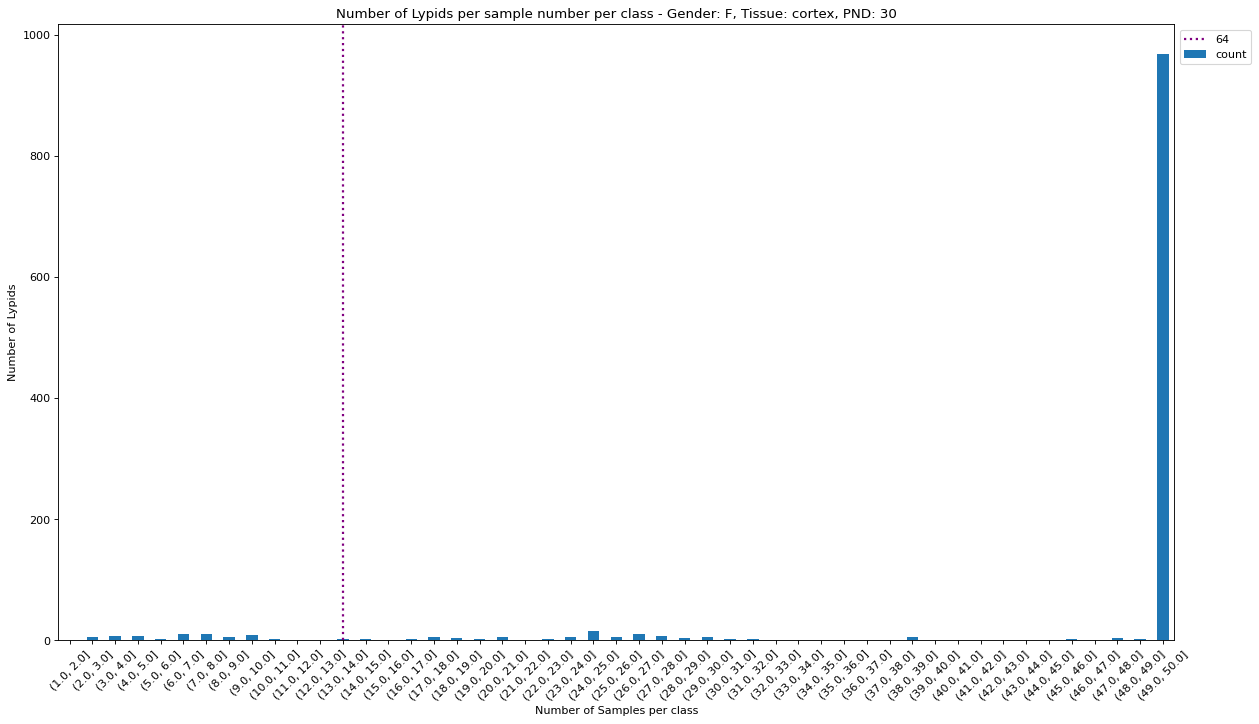

In [326]:
filename = 'histogram_number_of_samples_{}_{}_{}.png'.format(gender, tissue_type, pnd)
fig = plt.figure(figsize=(18,10),dpi=80)
hist_data.plot(kind='bar', title='Number of Lypids per sample number per class - Gender: {}, Tissue: {}, PND: {}'.format(gender, tissue_type, pnd))
plt.xlabel('Number of Samples per class')
plt.ylabel('Number of Lypids')
plt.xticks(rotation=45)

plt.axvline(x=12, color='purple', ls=':', lw=2, label=num_affected_lypids)

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
fig.savefig(os.path.join(data_path,filename), format='png', facecolor='w', dpi=100)

plt.show()

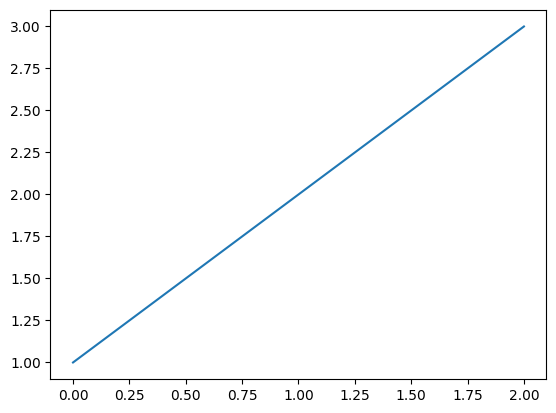

In [233]:
plt.plot([1,2,3])
plt.savefig('figure.png')